In [1]:
import torch
import xutorch
import torch.nn as nn

In [2]:
args = {
    'min_df': 5,
    'num_sentence_word': 100,
    'lr': 0.0005,
    'num_epochs': 200,
    'batch_size': 8,
    'early_stop': 50,
    'save_path': 'weights/hw3_model.pth'
}

In [3]:
train_loader, train_dataset = xutorch.dataset.prep_dataloader(
    dataset_name='Sentiment',
    download=False,
    train=True, 
    batch_size=args['batch_size'], 
    test_ratio=0.25, 
    min_df=args['min_df'], 
    num_sentence_word = args['num_sentence_word']
)
val_loader, val_dataset = xutorch.dataset.prep_dataloader(
    dataset_name='Sentiment',
    download=False,
    train=False, 
    batch_size=args['batch_size'], 
    test_ratio=0.25, 
    min_df=args['min_df'], 
    num_sentence_word = args['num_sentence_word']
)

Finished reading the train set of Text Dataset (4573 samples found), each dim = 5044
Finished reading the val set of Text Dataset (1500 samples found), each dim = 5044


In [4]:
# sorted_keys = sorted(train_dataset.word_to_idx.keys())[:100]
# for key in sorted_keys:
#     print(key)

In [5]:
xutorch.misc.set_seeds(42)

device = xutorch.misc.get_device()

# model = xutorch.model.EmbeddingMLP(input_dim=train_dataset.dim, hidden_dim=8192, output_dim=2).to(device)
model = xutorch.model.MLP(input_dim = args['num_sentence_word'], hidden_dim1=128, hidden_dim2=256, output_dim=2).to(device)

# 可读取模型权重接续训练
# state_dict = torch.load(args['save_path'])
# model.load_state_dict(state_dict)

# 创建一个CE损失函数
criterion = xutorch.loss.CrossEntropy()

# 创建一个Adam优化器
optimizer = xutorch.optim.SimpleAdam(model.parameters(), lr=args['lr'])

In [6]:
loss_record = {
    'train': [], 
    'val': []
}

best_val_acc = 0.0
best_val_acc_epoch = 0.0

early_stop_cnt = 0

for epoch in range(args['num_epochs']):
    train_acc = 0.0
    train_loss = 0.0

    model.train()
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        train_pred = torch.sign(outputs)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(train_pred.cpu(), labels.cpu())
        train_pred_labels = torch.argmax(train_pred, dim=1)
        train_acc += (train_pred_labels.cpu() == labels.cpu()).sum().item()
        train_loss += loss.item()
    loss_record['train'].append(train_loss / len(train_dataset))

    val_acc = 0.0
    val_loss = 0.0

    model.eval()
    for batch_idx, (inputs, labels) in enumerate(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            val_pred = torch.sign(outputs)

            loss = criterion(outputs, labels)

        val_pred_labels = torch.argmax(val_pred, dim=1)
        val_acc += (val_pred_labels.cpu() == labels.cpu()).sum().item()
        val_loss += loss.item()
    loss_record['val'].append(val_loss / len(val_dataset))

    if epoch == 0 or val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_acc_epoch = epoch
        print(f'Saving model (epoch = {epoch + 1 : 4d}, acc = {best_val_acc / len(val_dataset) : .4f})')
        torch.save(model.state_dict(), args['save_path'])
        early_stop_cnt = 0
    else:
        early_stop_cnt += 1
    
    if early_stop_cnt > args['early_stop']:
        print('**EARLY STOP**')
        break

    if epoch % 10 == 9:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
            epoch + 1, args['num_epochs'],
            train_acc / len(train_dataset), train_loss / len(train_dataset),
            val_acc / len(val_dataset), val_loss / len(val_dataset)))

Saving model (epoch =    1, acc =  0.8320)
Saving model (epoch =    2, acc =  0.8547)
Saving model (epoch =    3, acc =  0.8733)
Saving model (epoch =    4, acc =  0.8853)
Saving model (epoch =    6, acc =  0.8900)
Saving model (epoch =   10, acc =  0.8947)
[010/200] Train Acc: 0.895692 Loss: 0.039401 | Val Acc: 0.894667 loss: 0.092232
Saving model (epoch =   11, acc =  0.9093)
Saving model (epoch =   16, acc =  0.9120)
Saving model (epoch =   20, acc =  0.9187)
[020/200] Train Acc: 0.918872 Loss: 0.014198 | Val Acc: 0.918667 loss: 0.053652
Saving model (epoch =   22, acc =  0.9220)
[030/200] Train Acc: 0.912311 Loss: 0.011373 | Val Acc: 0.911333 loss: 0.038753
Saving model (epoch =   35, acc =  0.9240)
[040/200] Train Acc: 0.908157 Loss: 0.042239 | Val Acc: 0.910000 loss: 0.063794
[050/200] Train Acc: 0.916029 Loss: 0.038269 | Val Acc: 0.908667 loss: 0.069276
Saving model (epoch =   51, acc =  0.9267)
[060/200] Train Acc: 0.920621 Loss: 0.012680 | Val Acc: 0.922667 loss: 0.018538
[070

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

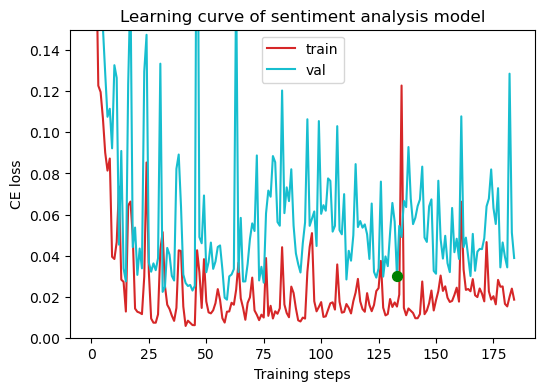

In [8]:
xutorch.plot.plot_learning_curve(loss_record, title='sentiment analysis model', loss_name='CE', bottom=0.0, top=0.15, min_loss_x=best_val_acc_epoch, min_loss_y=loss_record['val'][best_val_acc_epoch])